# Project: Building a Student Intervention System
## Goal: Evaluate Performance of Different Supervised Learning Models and Implement Parameter Tuning

In this project, we evaluate the performance and predictive power of different classification models on student performance data [provided by Udacity](https://github.com/udacity/machine-learning/tree/master/projects/student_intervention). We then pick the best of them and implement parameter tuning using Grid Search to improve its predictive performance on our testing set.

## Exploring the Data
We begin by importing some libraries and reading the data. Then, we investigate the dataset to determine how many students we have information on, and learn about the graduation rate among these students.

Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split

# Read student data
student_data = pd.read_csv("student-data.csv")

In [2]:
# Calculate number of students
nlines, ncol = student_data.loc[:,student_data.columns != 'passed'].shape
n_students = nlines

# Calculate number of features
n_features = ncol

# Calculate passing students
n_passed = len(student_data[student_data.passed == 'yes'])

# Calculate failing students
n_failed = len(student_data[student_data.passed == 'no'])

# Calculate graduation rate
grad_rate = float(n_passed)/n_students * 100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we prepare the data for modeling, training and testing.

### Identify feature and target columns
We first separate the student data into feature and target columns to see if any features are non-numeric.

In [3]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

Based on the data-head that we printed above, there are several non-numeric columns that need to be converted. Some of those columns (e.g.  `Mjob` and `Fjob`) contain _categorical variables_ (i.e. variables with more than two values). We deal with these columns by creating _dummy variables_, using the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) function to perform this transformation.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Training and Testing Data Split
After converting all _categorical_ features into numeric values we split the data (both features and corresponding labels) into training and test sets.

In [5]:
# Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# Shuffle and split the dataset into the number of training and testing points above
# Stratify will maintain the class imbalance across both sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=num_train, random_state=2, stratify=y_all)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, we compare supervised learning models that are appropriate for this problem and available in `scikit-learn`. More specifically, we compare Gaussian Naive Bayes, Decision Trees and Gradient Boosting. We fit all models to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score.

### Setup
The code cell below contains three helper functions which are used for training and testing the three supervised learning models we mentioned above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [6]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, we now import the three supervised learning models and run the `train_predict` function for each one.

In [7]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=1)
clf_C = GradientBoostingClassifier(random_state=1)

# Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train
y_train_300 = y_train

# Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
for clfi in [clf_A, clf_B, clf_C]:
    for X_traini, y_traini in [[X_train_100, y_train_100],[X_train_200, y_train_200],[X_train_300, y_train_300]]:
        train_predict(clfi, X_traini, y_traini, X_test, y_test)

Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0037 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8696.
Made predictions in 0.0008 seconds.
F1 score for test set: 0.7023.
Training a GaussianNB using a training set size of 200. . .
Trained model in 0.0012 seconds
Made predictions in 0.0005 seconds.
F1 score for training set: 0.8333.
Made predictions in 0.0009 seconds.
F1 score for test set: 0.6984.
Training a GaussianNB using a training set size of 300. . .
Trained model in 0.0029 seconds
Made predictions in 0.0007 seconds.
F1 score for training set: 0.8155.
Made predictions in 0.0005 seconds.
F1 score for test set: 0.7188.
Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0303 seconds
Made predictions in 0.0006 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0004 seconds.
F1 score for test set: 0.7218.
Training a DecisionTreeClassifier using a training set size of 200. 

### Tabular Results

The results are summarized below:

** Classifer 1 - Gaussian Naive Bayes**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0037           |      0.0008            |       0.8696     |     0.7023      |
| 200               |        0.0012           |      0.0009            |       0.8333     |     0.6984      |
| 300               |        0.0029           |      0.0005            |       0.8155     |     0.7188      |

** Classifer 2 - Decision Trees**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0303           |      0.0004            |       1.0000     |     0.7218      |
| 200               |        0.0016           |      0.0002            |       1.0000     |     0.7407      |
| 300               |        0.0025           |      0.0003            |       1.0000     |     0.7559      |

** Classifer 3 - Gradient Boosting**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.1224           |       0.0006           |       1.0000     |     0.7429      |
| 200               |        0.1129           |       0.0005           |       0.9928     |     0.7971      |
| 300               |        0.1232           |       0.0006           |       0.9639     |     0.7801      |

## Choosing the Best Model
From the tabular data presented above it seems that the gradient boosting model performs the best. For most training sets it seems to performs better on the test set than the corresponding results from the other models. Gradient boosting seems to perform especially well even with small data sets (training set of 100) comparing to the other models we tried. Its training time is greater than Gaussian Naive Bayes and Decision Trees but the prediction time is approximately the same in all cases. If we are given a large training set, as training time could become an important issue, we might choose to use the Gaussian Naive Bayes model.

### Implementation: Model Tuning
Here we fine tune the chosen model using grid search (`GridSearchCV`).

In [8]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Create the parameters list you wish to tune
parameters = {'n_estimators':[5,10,25,50,100,200],'max_depth':[2,3]}

# Initialize the classifier
clf = GradientBoostingClassifier(random_state=1)

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='yes')

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=f1_scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Best parameters picked:", grid_obj.best_params_
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Best parameters picked: {'n_estimators': 10, 'max_depth': 3}
Made predictions in 0.0010 seconds.
Tuned model has a training F1 score of 0.8596.
Made predictions in 0.0003 seconds.
Tuned model has a testing F1 score of 0.7973.


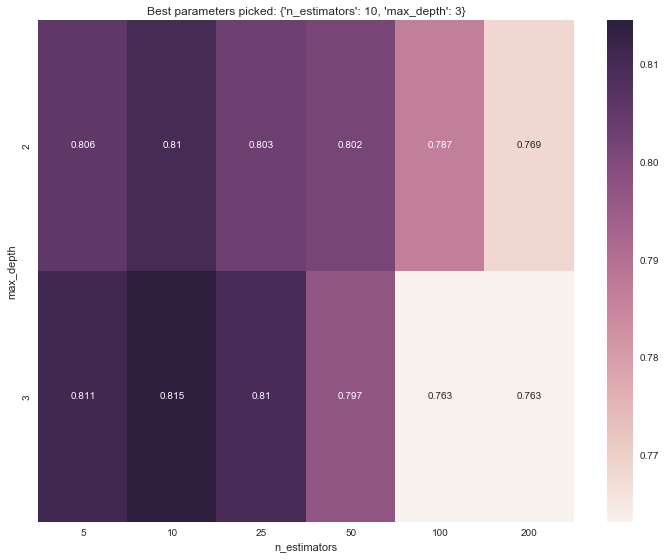

In [9]:
# Displaying the results using seaborn heatmap

# Import seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Make dataframe with tuning parameters as columns
grid_long = pd.DataFrame(grid_obj.grid_scores_)
grid_long['n_estimators'] = [i['n_estimators'] for i in grid_long.parameters]
grid_long['max_depth'] = [i['max_depth'] for i in grid_long.parameters]

# Pivot dataframe to set max_depth as index
grid = grid_long.pivot(index="max_depth",columns="n_estimators",values="mean_validation_score")

# Plot results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(grid, annot=True, fmt='.3g')
ax.set_title("Best parameters picked: {}".format(grid_obj.best_params_))

### Final F<sub>1</sub> Score
The final testing test score for a training set of 300 improved significantly, using 10 estimators (instead of 100) and a max depth of 3 (unchanged):

Final F1 score: 0.8596 (training), 0.7973 (testing).

Untuned F1 score: 0.9639 (training), 0.7801 (testing).

Now that we optimized our model using the F<sub>1</sub> score we can also evaluate the classification accuracy of the model for the parameters we picked above. This will give us a better idea of how well our parameters perform.

In [10]:
from sklearn.metrics import accuracy_score
y_guess = clf.predict(X_test)
print "Tuned model has a testing accuracy score of {:.4f}.".format(accuracy_score(y_test,y_guess))

Tuned model has a testing accuracy score of 0.6842.


The graduation rate is 67.09% and our accuracy score is 68.42%. This means that our model does not perform much better than a model that would predict that every student in the class will graduate.